In [5]:
!pip install pytorch-msssim


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import os
import sys
import math

# print(os.getcwd())
os.chdir('/workspace/NN')
# print(os.getcwd())
import torch
from torch import nn
from tqdm.notebook import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim
from torchvision import transforms
import pandas as pd
import seaborn as sns
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import numpy as np

sys.path.insert(0, '/workspace/NN/src/entropy_coder')
import EntropyCodec

orig_ssim = 0.7124563455581665

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:


# Настройка параметров
data_dir = './dataset/train'  # Путь к директории с изображениями
test_dir = './dataset/test'  # Путь к директории с изображениями
batch_size = 24  # Размер мини-батча
num_workers = 4  # Количество потоков для загрузки данных
shuffle = True  # Перемешивание данных
image_size = image_size_h = image_size_w = 128

# Преобразования данных
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображений
    transforms.ToTensor(),  # Преобразование изображений в тензоры
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Нормализация
    # transforms.Lambda(lambd=lambda x: x / 255.0)
])


# Кастомный Dataset для бесклассовой загрузки изображений
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Получаем список всех файлов в директории
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if
                            fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загрузка изображения по индексу
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Открываем изображение и конвертируем в RGB

        if self.transform:
            image = self.transform(image)  # Применяем преобразования

        return image


# Создание Dataset и DataLoader
dataset = ImageDataset(root_dir=data_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

x_train, x_val = train_test_split(dataset, train_size=0.8,
                                  random_state=42)
train_dataloader = DataLoader(dataset=x_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_dataloader = DataLoader(dataset=x_val, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

test_dataset = ImageDataset(root_dir=test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Пример использования DataLoader
print(len(x_train), len(x_val), len(test_dataset), len(dataset))


163 41 21 204


In [10]:
#Compresses input layer by multi-alphabet arithmetic coding using memoryless source model
def EntropyEncoder(filename, enclayers, size_z, size_h, size_w):
    temp = np.zeros((size_z, size_h, size_w), np.uint8, 'C')
    for z in range(size_z):
        for h in range(size_h):
            for w in range(size_w):
                temp[z][h][w] = enclayers[z][h][w]
    maxbinsize = (size_h * size_w * size_z)
    bitstream = np.zeros(maxbinsize, np.uint8, 'C')
    StreamSize = np.zeros(1, np.int32, 'C')
    EntropyCodec.HiddenLayersEncoder(temp, size_w, size_h, size_z, bitstream, StreamSize)
    with open(filename, 'wb') as fp:
        out = bitstream[0:StreamSize[0]]
        out.astype('uint8').tofile(fp)


#Decompresses input layer by multi-alphabet arithmetic coding using memoryless source model
def EntropyDecoder(filename, size_z, size_h, size_w):
    # path = './notebooks/tmp'
    with open(filename, 'rb') as fp:
        bitstream = fp.read()

    bitstream = np.frombuffer(bitstream, dtype=np.uint8)
    declayers = np.zeros((size_z, size_h, size_w), np.uint8, 'C')
    FrameOffset = np.zeros(1, np.int32, 'C')
    FrameOffset[0] = 0
    EntropyCodec.HiddenLayersDecoder(declayers, size_w, size_h, size_z, bitstream, FrameOffset)
    return torch.tensor(declayers)


#Compute PSNR in RGB domain
def PSNR_RGB(image1, image2):
    width, height = image1.size
    I1 = np.array(image1.getdata()).reshape(image1.size[0], image1.size[1], 3)
    I2 = np.array(image2.getdata()).reshape(image2.size[0], image2.size[1], 3)
    I1 = np.reshape(I1, width * height * 3)
    I2 = np.reshape(I2, width * height * 3)
    I1 = I1.astype(float)
    I2 = I2.astype(float)
    mse = np.mean((I1 - I2) ** 2)
    if (mse == 0):  # MSE is zero means no noise is present in the signal .
        psnr = 100.0
    else:
        max_pixel = 255.0
        psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    #print("PSNR = %5.2f dB" % psnr)
    return psnr


#This function is searching for the JPEG quality factor (QF)
#which provides neares compression to TargetBPP
def JPEGRDSingleImage(x, target_bpp):
    x = (x * 255).permute(1, 2, 0)
    # print(x.size())
    image = Image.fromarray(x.cpu().numpy().astype('uint8'), 'RGB')
    width, height = image.size
    # print('image', width, height)
    realbpp = 0
    realpsnr = 0
    realQ = 0
    for Q in range(101):
        image.save('test.jpeg', "JPEG", quality=Q)
        image_dec = Image.open('test.jpeg')
        bytesize = os.path.getsize('test.jpeg')
        bpp = bytesize * 8 / (width * height)
        psnr = PSNR_RGB(image, image_dec)
        if abs(realbpp - target_bpp) > abs(bpp - target_bpp):
            realbpp = bpp
            realpsnr = psnr
            realQ = Q
    image.save('test.jpeg', "JPEG", quality=realQ)
    image_dec = Image.open('test.jpeg')
    # print(image)
    # print(image.getdata())
    # I1 = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    I2 = torch.tensor(image_dec.getdata()).reshape(image_dec.size[0], image_dec.size[1], 3).permute(2, 0, 1)
    # image.save('test.jpeg', "JPEG", quality=realQ)
    # image_dec = Image.open('test.jpeg')
    # I1 = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    # I2 = torch.tensor(image_dec.getdata())
    # print(I1.shape, I2.shape)

    return realQ, realbpp, realpsnr, (I2 / 255)


def neural_compressor(latent, bits_to_neuron_count, divided_on_max=False):
    print('neural_compressor start')
    #Run the model for first NumImagesToShow images from the test set
    path = './notebooks/tmp'
    if divided_on_max:
        bath_maxes = torch.amax(latent, dim=(1, 2, 3))
        latent /= bath_maxes.view(-1, 1, 1, 1)
    if bits_to_neuron_count == 8:
        mn = pow(2, bits_to_neuron_count) - 1
    else:
        mn = pow(2, bits_to_neuron_count)

    #Quantization of layer to b bits
    print('torch.round', )
    print(pow(2, bits_to_neuron_count))
    latent = torch.round((latent * mn)).type(torch.int32)
    print(latent.size(), latent.min(), latent.max())

    #Encoding and decoding of each quantized layer by arithmetic coding
    bpp = torch.zeros(latent.size()[0], dtype=torch.float16)
    recover_latent = torch.zeros((latent.size()[0], 16, 16, 16), dtype=torch.uint8)
    for i in range(latent.size()[0]):
        bin_filename = 'image%i.bin' % i
        bin_filename = os.path.join(path, bin_filename)
        print('----')
        EntropyEncoder(bin_filename, latent[i], 16, 16, 16)
        print('----')
        bytesize = os.path.getsize(bin_filename)
        print('----', bytesize)
        bpp[i] = bytesize * 8 / (image_size_w * image_size_h)
        print('----')
        recover_latent[i] = EntropyDecoder(bin_filename, 16, 16, 16)
        print('----')

    recover_latent = recover_latent.to(torch.float32) / mn
    return recover_latent, bpp


In [14]:
# _, latent, _ = model_with_noize.forward(list(test_dataloader)[0][0:5], add_clipping=None, add_noize=False)

In [ ]:
# latent.size()
# res = [neural_compressor(latent[i:i + 1], 8) for i in range(latent.size()[0])]
# res[0]

In [53]:
# jpeg_data = [
#     [(realbpp, calculate_ssim(in_img[None, ...], I2[None, ...])) for ((realQ, realbpp, realpsnr, I2), in_img) in
#      ((JPEGRDSingleImage(in_img, i), in_img) for in_img in list(test_dataloader)[0][:5])]
#     for i in [5]]
# jpeg_data = list(zip(*[ii for i in jpeg_data for ii in i]))
# jpeg_data

[(5.19873046875, 4.787109375, 4.80126953125, 5.11572265625, 5.19921875),
 (0.9830705523490906,
  0.9804840087890625,
  0.9797566533088684,
  0.9783652424812317,
  0.9878469109535217)]

In [11]:
bt = 2


class CNNImageCodec(nn.Module):

    def __init__(self, n1M1=128, n2M1=32, n3M1=16, latent_space=16 * 16 * 16, add_noize=False):
        super(CNNImageCodec, self).__init__()
        self.add_noize = add_noize
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n1M1, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(n1M1),
            nn.Conv2d(n1M1, n2M1, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(n2M1),
            nn.Conv2d(n2M1, n3M1, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(n3M1),
            # nn.Conv2d(n3M1, n3M1, kernel_size=1),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.BatchNorm2d(n3M1),
            # nn.Conv2d(n3M1, n3M1, kernel_size=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(n3M1),
            nn.ConvTranspose2d(n3M1, n2M1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n2M1),
            nn.ConvTranspose2d(n2M1, n1M1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n1M1),
            nn.ConvTranspose2d(n1M1, 3, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, add_clipping: int | None = None, add_noize=True):
        batch_size = x.size(0)
        conv_res: torch.Tensor = self.encoder(x)
        conv_size = conv_res.size()
        if add_noize and self.add_noize:
            maxt = conv_res.max().to(conv_res.device)
            # torch.FloatTensor(16,16,16).uniform_(-1.0/pow(2, bt+1), high=1.0/pow(2, bt+1))
            conv_res = conv_res + maxt * (
                torch.FloatTensor(16, 16, 16).uniform_(-1.0 / pow(2, bt + 1), 1.0 / pow(2, bt + 1)).to(conv_res.device))
        if add_clipping is not None:
            # conv_res = torch.round(conv_res * pow(2, add_clipping)) / pow(2, add_clipping)
            conv_res, bpp = neural_compressor(conv_res, add_clipping, divided_on_max=False)
            conv_res = conv_res.to(x.device)
        else:
            bpp = -1
        # print(x.device, conv_res.device)
        # bath_maxes = torch.amax(conv_res, dim=(1, 2, 3))
        # print(bath_maxes.size())
        # conv_res = conv_res / bath_maxes.view(-1, 1, 1, 1)

        # latent = self.encoder_linear(conv_res.view(batch_size, -1))
        # after_latent = self.decode_liner(latent).view(*conv_size)
        # print(latent.size())
        after_latent = latent = conv_res

        res = self.decoder(after_latent)  # .view(*conv_size)
        return res, latent, bpp


In [12]:
def vae_loss_function(recon_x, x, logvar, KL_weight=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='none')
    MSE = torch.div(MSE, torch.numel(x))
    MSE = torch.sum(MSE)
    KLD = -0.5 * torch.sum(1 + logvar - logvar.exp())
    KLD = torch.div(KLD, x.shape[0])
    # l1_lambda = 0.001
    # l1_reg = sum(p.sum() for p in model.parameters())
    # l2_reg = sum(p.pow(2).sum() for p in model.parameters())
    # MSE += l2_reg * l1_lambda
    # MSE += l1_reg * l1_lambda

    return MSE, KLD


def PSNR(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100.0
    max_pixel = 1.0
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))


def kl_divergence(input_image, reconstructed_image):
    # Вычисление распределений вероятностей для изображений
    input_image_probs = F.softmax(input_image.flatten(start_dim=1), dim=-1)
    reconstructed_image_probs = F.softmax(reconstructed_image.flatten(start_dim=1), dim=-1)

    # KL-дивергенция для изображений
    image_kl = F.kl_div(
        input_image_probs.log(),
        reconstructed_image_probs,
        reduction="batchmean"
    )

    return image_kl.item()


def calculate_ssim(input_image, output_image):
    assert input_image.shape == output_image.shape, f"Размеры входного и выходного изображений должны совпадать., {input_image.shape} {output_image.shape}"
    # Создание экземпляра метрики SSIM
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(
        device)  # Ожидается, что изображения нормализованы [0, 1]
    if input_image.max() > 1.0:
        input_image = input_image / 255.0
    if output_image.max() > 1.0:
        output_image = output_image / 255.0
    ssim_score = ssim_metric(input_image, output_image)
    return ssim_score.mean().item()


def calculate_bpp_from_tensor(encoded_tensor, image_shape):
    bits_per_element = encoded_tensor.element_size() * 8  # Размер одного элемента в битах
    total_bits = encoded_tensor.numel() * bits_per_element  # Общее количество бит
    num_pixels = image_shape[1] * image_shape[2]
    bpp = total_bits / num_pixels
    return bpp


def get_metrics(input_img, recovered_mg, latent_spase, container: dict[str, list[float]], stage='train/'):
    mse_loss, kld_loss = vae_loss_function(recovered_mg, input_img, latent_spase)
    container[f'{stage}kld_loss'].append(kld_loss.item())
    container[f'{stage}kld'].append(kl_divergence(input_img, recovered_mg))
    container[f'{stage}mse_loss'].append(mse_loss.item())
    container[f'{stage}SSID'].append(
        ms_ssim(input_img, recovered_mg, data_range=1, size_average=False, win_size=7).mean().item())
    container[f'{stage}SSID_1'].append(calculate_ssim(input_img, recovered_mg))
    container[f'{stage}PSNR'].append(PSNR(input_img, recovered_mg).item())
    container[f'{stage}bpp'].append(latent_spase.size()[1] / (input_img.size()[2] * input_img.size()[3]))
    container[f'{stage}bpp_1'].append(calculate_bpp_from_tensor(latent_spase[0], input_img.size()[1:]) / 24)

    return container, kld_loss, mse_loss



In [13]:

scheduler_epochs_step = 400

model = CNNImageCodec(add_noize=True).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=3 * 10e-4)
loss_fn = vae_loss_function
scheduler = StepLR(optimizer, step_size=scheduler_epochs_step, gamma=0.1)

In [14]:
for images in train_dataloader:
    with torch.no_grad():
        model = model.cpu()
        test, latent, *_ = model(images.cpu())
        assert test.size() == images.size(), f"{test.size()} {images.size()}"
        assert images.max() <= 1 and images.min() >= 0, f"min max items {images.min()} {images.max()}"

        test_loss = loss_fn(images, test, latent)
        bits_per_element = latent[0].element_size() * 6  # Размер одного элемента в битах
        total_bits = latent[0].numel() * bits_per_element  # Общее количество бит
        num_pixels = images.size()[2] * images.size()[3]
        bpp = total_bits / num_pixels
        print(bpp / 24, "|", latent[0].numel(), bits_per_element, "|", num_pixels)

        break  # Остановка после одного батча для примера

0.25 | 4096 24 | 16384


In [15]:
model = model.to(device)

In [16]:
def learn_callback(curr_model, metrics_container, curr_epoch):
    eval_loss = validation(curr_model, metrics_container)
    KLD_loss = metrics_container['val/kld']
    mse_loss = metrics_container['val/mse_loss']
    ssim_loss = metrics_container['val/SSID_1']
    bpp = metrics_container['val/bpp_1']
    if curr_epoch % 50 == 0:
        print(
            f'Epoch: {epoch + 1:02} | mse={mse_loss[-1]:.5f}|{eval_loss:.5f}, kld={KLD_loss[-1]:.5f} ssim={metrics_container["train/SSID_1"][-1]:.5f}|{ssim_loss[-1]:.5f}, bpp={bpp[-1]:.5f}')


def train_epoch(curr_model, curr_dataloader, callback_fun, metrics_container, curr_epoch):
    curr_model.train()
    # losses = []

    for images_batch in curr_dataloader:
        optimizer.zero_grad()
        images_batch = images_batch.to(device)
        recovered_images, latent, *_ = curr_model(images_batch)
        # loss_fn(recovered_images, images_batch, latent)
        metrics_container, loss_KDE, loss_mse = get_metrics(images_batch, recovered_images, latent, metrics_container)
        # loss_KDE.backward()
        loss_mse.backward()
        optimizer.step()
        # losses.append(loss_KDE.item())
    curr_model.train()
    callback_fun(curr_model, metrics_container, curr_epoch=curr_epoch)
    return metrics_container


def validation(curr_model, metrics_container):
    global val_dataloader
    curr_model.eval()
    losses = []
    with torch.no_grad():
        for images_batch in val_dataloader:
            images_batch = images_batch.to(device)
            recovered_images, latent, *_ = curr_model.forward(images_batch, add_noize=False)
            metrics_container, loss_KDE, loss_mse = get_metrics(images_batch, recovered_images, latent,
                                                                metrics_container, stage='val/')
            # loss_mse, loss_KLD = loss_fn(recovered_images, images_batch, latent)
            losses.append(loss_mse.item())
    return sum(losses) / len(losses)



In [17]:

metrics_container = {
    'val/bpp': [],
    'val/kld_loss': [],
    'val/mse_loss': [],
    'val/PSNR': [],
    'val/SSID': [],
    'val/kld': [],
    "val/SSID_1": [],
    "val/bpp_1": [],
    'train/bpp': [],
    'train/kld_loss': [],
    'train/mse_loss': [],
    'train/PSNR': [],
    'train/SSID': [],
    'train/kld': [],
    "train/SSID_1": [],
    "train/bpp_1": [],
}
validation(model, metrics_container)
epochs_count = 2000
epoch = 0
for epoch in trange(epochs_count + 1, desc='Total', ):
    metrics_container = train_epoch(model, train_dataloader, learn_callback, metrics_container, epoch)
    scheduler.step()
    # break
validation(model, metrics_container)



Total:   0%|          | 0/2001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
# %matplotlib inline
#

NumImagesToShow = 5


# Visualize results with larger plots

def ssim_calc(model, clipping=None, draw=False):
    print(clipping)
    if draw:
        fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер всей фигуры (ширина x высота в дюймах)
    model = model.to(device)
    for images in test_dataloader:
        with torch.no_grad():

            recovered_img, latent, bpp = model.forward(images.to(device), add_clipping=clipping, add_noize=False)
            images = images.cpu()
            recovered_img = recovered_img.cpu()
            if draw:
                for i in range(NumImagesToShow):
                    # Original images
                    ax1 = fig.add_subplot(2, NumImagesToShow, i + 1)
                    ax1.imshow(images[i].permute(1, 2, 0).cpu().numpy())
                    ax1.axis('off')
                    ax1.set_title("Original", fontsize=12)

                    # Reconstructed images
                    ax2 = fig.add_subplot(2, NumImagesToShow, NumImagesToShow + i + 1)
                    ax2.imshow(recovered_img[i].permute(1, 2, 0).cpu().numpy())
                    ax2.axis('off')
                    psnr_value = calculate_ssim(images[i:i + 1], recovered_img[i:i + 1])
                    ax2.set_title(f"Reconstructed\nSSIM {psnr_value:.5f}\nbpp: {bpp:.5f}", fontsize=12)

    if draw:
        plt.tight_layout()  # Для автоматического выравнивания графиков
        plt.show()
    modified_ssim = calculate_ssim(images, recovered_img)
    # print(modified_ssim)
    # torch.save(model.state_dict(), f"weights/modification_autoencoder_{epoch}_ssim_{modified_ssim:.05f}.pth")
    # print(len(test_dataloader))
    model.cpu()
    return modified_ssim, bpp
    # assert modified_ssim - orig_ssim > 0.05, f"Недостаточно по качеству {modified_ssim - orig_ssim} < 0.05"



In [12]:
modified_ssim, *_ = ssim_calc(model, None)
torch.save(model.state_dict(), f"weights/modification_autoencoder_{epoch}_ssim_{modified_ssim:.05f}.pth")

None


NameError: name 'epoch' is not defined

7


TypeError: unsupported format string passed to Tensor.__format__

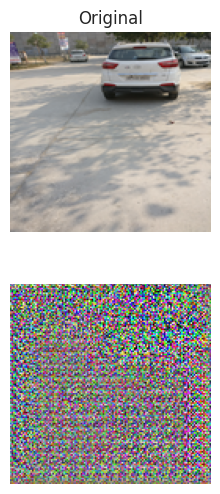

In [13]:
# ssim_calc(model, 4)
ssim_calc(model, 7, draw=True)

In [23]:
# from data3 import data as codecs_res_data_jpeg
# from data import data as codecs_res_data
#
# # data = {'ae2': {2: [[[23,34,5]]]}}
# ae2_res = {(k): calculate_ssim(list(test_dataloader)[0][:10], torch.tensor(v).permute(0, 3, 1, 2)) for k, v in codecs_res_data['AE2'].items()}
# jpeg_res = {k:  torch.tensor(v).permute(2, 0, 1) for k, (v) in codecs_res_data_jpeg['JPEG'].items()}
# jpeg_res2 = {}
# for k, v in jpeg_res.items():
#     jpeg_res2[round(k)] = jpeg_res2.get(round(k), []) + [v[None, ...]]
# jpeg_res2 = {k: torch.concatenate(v, dim=0) for k, v in jpeg_res2.items()}
# jpeg_res2 = {k: calculate_ssim(list(test_dataloader)[0][:10], torch.tensor(v)) for k, v in jpeg_res2.items()}
# {k: v for k, v in jpeg_res2.items()}
print("--")
jpeg_data = [
    [(realbpp, calculate_ssim(in_img[None, ...], I2[None, ...])) for ((realQ, realbpp, realpsnr, I2), in_img) in
     ((JPEGRDSingleImage(in_img, i), in_img) for in_img in list(test_dataloader)[0])]
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 5]]
jpeg_data = list(zip(*[ii for i in jpeg_data for ii in i]))


--


In [26]:
b_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] + list(range(1, 8))

model_with_noize = CNNImageCodec(add_noize=True)
model_with_noize.load_state_dict(
    torch.load('./weights/with_noize_autoencoder_2000_ssim_0.82743.pth', weights_only=True))
model_with_noize.eval()
my_solution_with_noize = list(zip(*[ssim_calc(model_with_noize, i) for i in b_param]))

model_without_noize = CNNImageCodec(add_noize=True)
model_without_noize.load_state_dict(
    torch.load('./weights/without_noize_autoencoder_2000_ssim_0.87755.pth', weights_only=True))
model_without_noize.eval()
my_solution_without_noize = list(zip(*[ssim_calc(model_without_noize, i) for i in b_param]))

old_neural_with_noize = Autoencoder(add_noize=True)
old_neural_with_noize.load_state_dict(torch.load('./weights/orig_autoencoder_with_noize.pth', weights_only=True))
old_neural_with_noize.eval()
old_neural_with_noize_res = list(zip(*[ssim_calc(old_neural_with_noize, i) for i in b_param]))

old_neural = Autoencoder(add_noize=False)
old_neural.load_state_dict(torch.load('./weights/orig_autoencoder.pth', weights_only=True))
old_neural.eval()
old_neural_res = list(zip(*[ssim_calc(old_neural, i) for i in b_param]))


0.1
neural_compressor start
torch.round
1.0717734625362931
torch.Size([21, 16, 16, 16]) tensor(0, device='cuda:0', dtype=torch.int32) tensor(1, device='cuda:0', dtype=torch.int32)
----
----
---- 670
----
----
----
----
---- 687
----
----
----
----
---- 685
----
----
----
----
---- 680
----
----
----
----
---- 667
----
----
----
----
---- 673
----
----
----
----
---- 679
----
----
----
----
---- 686
----
----
----
----
---- 681
----
----
----
----
---- 684
----
----
----
----
---- 687
----
----
----
----
---- 686
----
----
----
----
---- 673
----
----
----
----
---- 676
----
----
----
----
---- 679
----
----
----
----
---- 679
----
----
----
----
---- 686
----
----
----
----
---- 683
----
----
----
----
---- 686
----
----
----
----
---- 670
----
----
----
----
---- 679
----
----
0.2
neural_compressor start
torch.round
1.148698354997035
torch.Size([21, 16, 16, 16]) tensor(0, device='cuda:0', dtype=torch.int32) tensor(1, device='cuda:0', dtype=torch.int32)
----
----
---- 657
----
----
---

In [11]:
# df = pd.DataFrame({
#     'AV2': ae2_res.values(),
#     'JPEG': jpeg_res2.values(),
#     'neural without noize': my_solution_without_noize[1:len(ae2_res)+1],
#     'neural with noize': my_solution_with_noize[1:len(ae2_res)+1],
#     'old_neural': old_neural[1:len(ae2_res)+1],
# }, index=ae2_res.keys())
# ax = sns.lineplot(data=df)
# ax.set_xlabel('bpp')
# ax.set_ylabel('SSIM')

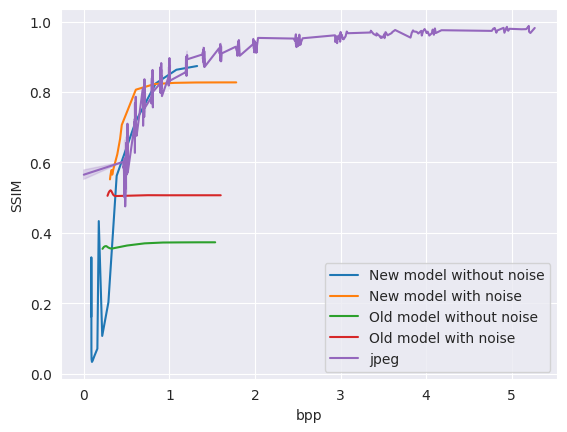

In [27]:
# old_neural_with_noize_res = list(old_neural_with_noize_res)
# old_neural_res = list(old_neural_res)
df = pd.DataFrame({
    'new SSIM': my_solution_without_noize[0],
    'new bpp': [sum([ii.item() for ii in i]) / len(i) for i in my_solution_without_noize[1]],
    'new noize SSIM': my_solution_with_noize[0],
    'new noize bpp': [sum([ii.item() for ii in i]) / len(i) for i in my_solution_with_noize[1]],
    'old SSIM': old_neural_res[0],
    'old bpp': [sum([ii.item() for ii in i]) / len(i) for i in old_neural_res[1]],
    'old noize SSIM': old_neural_with_noize_res[0],
    'old noize bpp': [sum([ii.item() for ii in i]) / len(i) for i in old_neural_with_noize_res[1]],
    'b param': b_param,
}, )
jpeg_df = pd.DataFrame({
    'jpeg SSIM': jpeg_data[1],
    'jpeg bpp': jpeg_data[0],
})
ax = sns.lineplot(data=df, x='new bpp', y='new SSIM', label='New model without noise')
ax = sns.lineplot(data=df, x='new noize bpp', y='new noize SSIM', label='New model with noise', ax=ax)
ax = sns.lineplot(data=df, x='old bpp', y='old SSIM', label='Old model without noise', ax=ax)
ax = sns.lineplot(data=df, x='old noize bpp', y='old noize SSIM', label='Old model with noise', ax=ax)
ax = sns.lineplot(data=jpeg_df, x='jpeg bpp', y='jpeg SSIM', label='jpeg', ax=ax)

# Настройка графика
ax.set_xlabel('bpp')
ax.set_ylabel('SSIM')
ax.legend(loc='best')  # Добавление легенды

# jpeg_data = list(zip(*[i[0] for i in jpeg_data]))

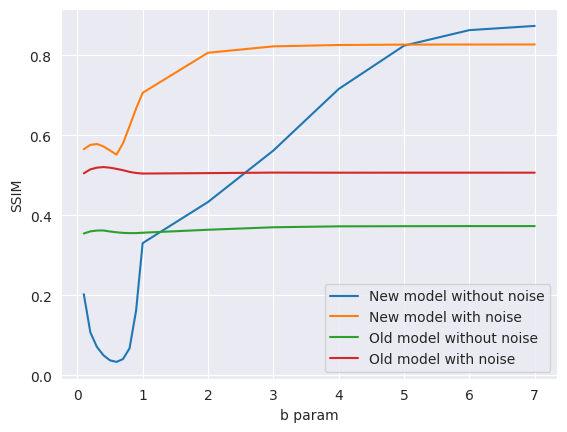

In [28]:
ax = sns.lineplot(data=df, x='b param', y='new SSIM', label='New model without noise')
ax = sns.lineplot(data=df, x='b param', y='new noize SSIM', label='New model with noise', ax=ax)
ax = sns.lineplot(data=df, x='b param', y='old SSIM', label='Old model without noise', ax=ax)
ax = sns.lineplot(data=df, x='b param', y='old noize SSIM', label='Old model with noise', ax=ax)

# Настройка графика
ax.set_xlabel('b param')
ax.set_ylabel('SSIM')
ax.legend(loc='best')

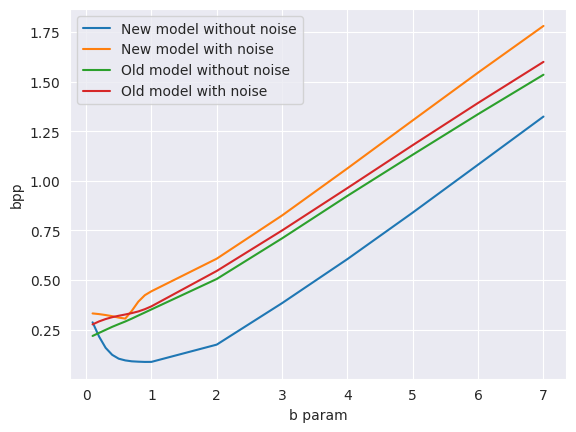

In [29]:
ax = sns.lineplot(data=df, y='new bpp', x='b param', label='New model without noise')
ax = sns.lineplot(data=df, y='new noize bpp', x='b param', label='New model with noise', ax=ax)
ax = sns.lineplot(data=df, y='old bpp', x='b param', label='Old model without noise', ax=ax)
ax = sns.lineplot(data=df, y='old noize bpp', x='b param', label='Old model with noise', ax=ax)
# ax = sns.lineplot(data=jpeg_df, x='jpeg bpp', y='jpeg SSIM', label='jpeg', ax=ax)

# Настройка графика
ax.set_xlabel('b param')
ax.set_ylabel('bpp')
ax.legend(loc='best')  # Добавление легенды

In [11]:
_, latent, _ = model_with_noize.forward(list(test_dataloader)[0][0:1], add_clipping=True, add_noize=False)

In [14]:
latent.size()
latent.min()


tensor(0.)

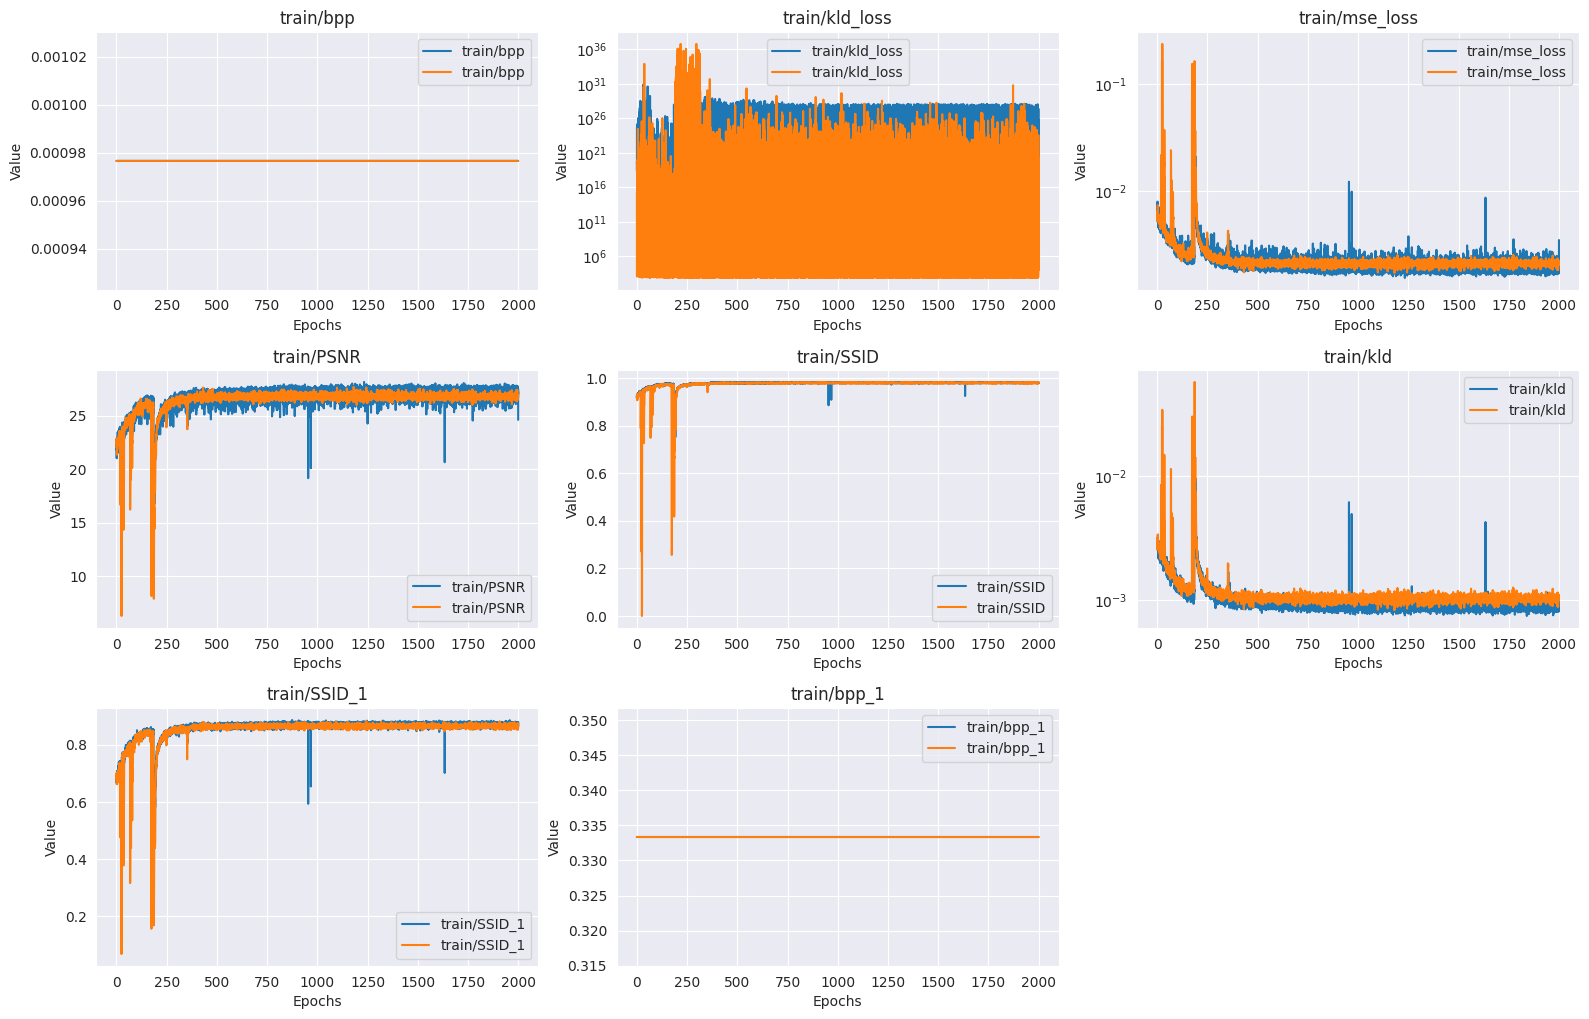

In [101]:
# epochs_count = 500
# Построение графиков
plt.figure(figsize=(16, 20))  # Размер фигуры
num_metrics = len(metrics_container)  # Количество метрик

for i, (key, values) in enumerate((filter(lambda i: i[0].startswith('train/'), metrics_container.items())), 1):
    plt.subplot((num_metrics + 2) // 3, 3, i)  # Распределяем графики по строкам и столбцам
    plt.plot([i * epochs_count / len(values) for i in range(len(values))], values, label=key)  # Линия графика
    # str.removeprefix()
    validation_values = metrics_container[f'val/{key.removeprefix("train/")}']
    plt.plot([i * epochs_count / len(validation_values) for i in range(len(validation_values))], validation_values,
             label=key)  # Линия графика
    plt.title(key)  # Название графика
    plt.xlabel('Epochs')  # Подпись оси X
    plt.ylabel('Value')  # Подпись оси Y
    # ax2.set_yscale('log')
    # ax2.set_xscale('log')
    # plt.xscale('log')
    if any([i in key for i in ['mse', 'kld']]):
        plt.yscale('log')

    plt.grid(True)  # Сетка
    plt.legend()  # Легенда

# Отображение всех графиков
plt.tight_layout()  # Компактное расположение
plt.show()

In [25]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import imghdr
import torch
import torch.nn as nn
import torch.optim as optim

# Constants
testfolder = './dataset/test/'
trainfolder = './dataset/train/'
w, h = 128, 128
LoadModel = 0
bt = 2
epochs = 2000
batch_sizeM1 = 24
n1M1, n2M1, n3M1 = 128, 32, 16
NumImagesToShow = 5
b = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load images from folder
def LoadImagesFromFolder(foldername):
    dir_list = os.listdir(foldername)
    images = []
    for name in dir_list:
        fullname = foldername + name
        filetype = imghdr.what(fullname)
        if filetype is not None:
            image = Image.open(fullname).resize((w, h))
            images.append(np.array(image))
    images = np.array(images, dtype=np.float32) / 255.0
    return torch.tensor(images).permute(0, 3, 1, 2)  # Convert to PyTorch format


# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, add_noize=False):
        super(Autoencoder, self).__init__()
        self.add_noize = add_noize
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n1M1, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(n1M1, n2M1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(n2M1, n3M1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n3M1, n2M1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(n2M1, n1M1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(n1M1, 3, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, add_clipping: int | None = None, add_noize=True):
        encoded = self.encoder(x)
        conv_res = encoded
        if add_noize and self.add_noize:
            maxt = conv_res.max().to(conv_res.device)
            # torch.FloatTensor(16,16,16).uniform_(-1.0/pow(2, bt+1), high=1.0/pow(2, bt+1))
            conv_res = conv_res + maxt * (
                torch.FloatTensor(16, 16, 16).uniform_(-1.0 / pow(2, bt + 1), 1.0 / pow(2, bt + 1)).to(conv_res.device))
        if add_clipping is not None:
            # conv_res /= conv_res.max()
            # conv_res = torch.round(conv_res * pow(2, add_clipping)) / pow(2, add_clipping)
            conv_res, bpp = neural_compressor(conv_res, add_clipping, divided_on_max=True)
            conv_res = conv_res.to(x.device)
        else:
            bpp = -1

        decoded = self.decoder(conv_res)
        return decoded, conv_res, bpp


# Train autoencoder
def train_model(train_images):
    old_model = Autoencoder(add_noize=True).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(old_model.parameters(), lr=1e-3)

    train_images = train_images.to(device)
    for epoch in range(epochs):
        old_model.train()
        optimizer.zero_grad()
        outputs, *_ = old_model(train_images)
        loss = criterion(outputs, train_images)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    torch.save(old_model.state_dict(), "./weights/orig_autoencoder_with_noize.pth")
    return old_model


LoadModel = 1
# Main function
# if __name__ == "__main__":
#     # Load test and train images
#     xtest = LoadImagesFromFolder(testfolder)
#     xtrain = LoadImagesFromFolder(trainfolder)
#
#     # Train or load model
#     if LoadModel == 0:
#         old_model = train_model(xtrain)
#     else:
#         old_model = Autoencoder().to(device)
#         old_model.load_state_dict(torch.load("./weights/orig_autoencoder.pth"))
#         old_model.eval()
#
#     xtest = xtest.to(device)
#     with torch.no_grad():
#         decoded, encoded = old_model(xtest)



/tmp/ipykernel_6038/467234230.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


AttributeError: 'Autoencoder' object has no attribute 'save'

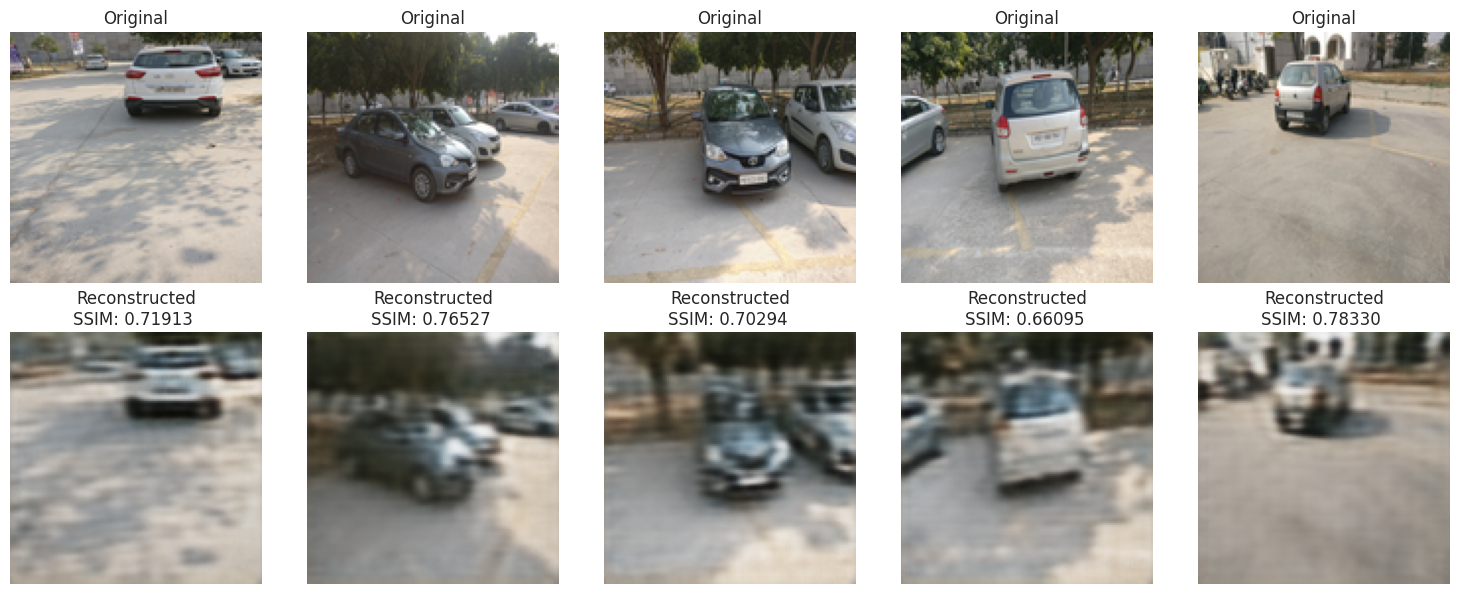

0.7128220796585083


In [169]:
# Visualize results with larger plots
fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер всей фигуры (ширина x высота в дюймах)
for i in range(NumImagesToShow):
    # Original images
    ax1 = fig.add_subplot(2, NumImagesToShow, i + 1)
    ax1.imshow(xtest[i].permute(1, 2, 0).cpu().numpy())
    ax1.axis('off')
    ax1.set_title("Original", fontsize=12)

    # Reconstructed images
    ax2 = fig.add_subplot(2, NumImagesToShow, NumImagesToShow + i + 1)
    ax2.imshow(decoded[i].permute(1, 2, 0).cpu().numpy())
    ax2.axis('off')
    psnr_value = calculate_ssim(xtest[i:i + 1], decoded[i:i + 1])
    ax2.set_title(f"Reconstructed\nSSIM: {psnr_value:.5f} ", fontsize=12)

# Show the plot
plt.tight_layout()  # Для автоматического выравнивания графиков
plt.show()
orig_ssim = calculate_ssim(xtest, decoded)
print(orig_ssim)


